In [1]:
import cuqi
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io

from cuqipy_cil.model import ParallelBeam2DModel, FanBeam2DModel
import cuqipy_cil

import subprocess
try:
    subprocess.check_output('nvidia-smi')
    print('Nvidia GPU detected!')
except Exception: # this command not being found can raise quite a few different errors depending on the configuration
    print('No Nvidia GPU in system!')


Nvidia GPU detected!


# Setup CT Problem

To setup and solve a CT problem we need a forward model and a dataset. 


#### Dataset

We use a dataset from HTC 2022. It is available at https://zenodo.org/record/6937616#.YzrjoGdBybg and described at https://www.fips.fi/HTCdata.php#anchor1. 
Below we load the dataset and wrap it in CUQIpy geometry:

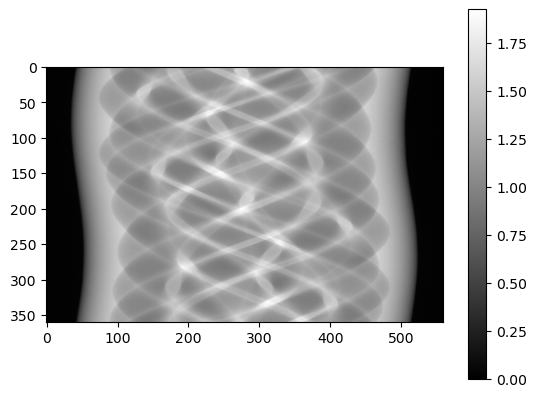

In [2]:
# Acquisition data and geometry parameters
mat = scipy.io.loadmat("../htc2022_tb_full.mat")
sinogram_full = mat['CtDataFull'][0][0][1].astype('float32')
num_dets = sinogram_full.shape[1]
source_center = 410.66
source_detector = 553.74
det_pixel_size = 0.2
mag = source_detector / source_center

# Choose number of angles and angular range
# The full dataset has a 2*pi angular range and 720 view angles. 
num_angles = 360#int(360/4) 
range_angles = (0,2*np.pi)#(0, np.pi/2) 

# Subsample sinogram and projection angles
sinogram = sinogram_full[int(range_angles[0]/np.pi*360):int(range_angles[1]/np.pi*360):int((range_angles[1]-range_angles[0])/np.pi*360/num_angles),:]
angles = np.linspace(0,2*np.pi,720,endpoint=True)[int(range_angles[0]/np.pi*360):int(range_angles[1]/np.pi*360):int((range_angles[1]-range_angles[0])/np.pi*360/num_angles)]

# Wrap data in CUQIpy geometry and plot
data = cuqi.samples.CUQIarray(sinogram.flatten(order="C"), is_par=True, geometry=cuqi.geometry.Image2D((num_angles, num_dets)))
data.plot()
plt.colorbar()


#### CT Model
The CT forward model can be setup convinently with the cil-plugin to CUQIpy. 

In [3]:
# Define CT model conveniently with cil-plugin
N = 500 # reconstruction dimension NxN
model = FanBeam2DModel(det_count=num_dets, 
                        det_spacing = det_pixel_size,
                        angles=-angles,
                        source_object_dist = source_center,
                        object_detector_dist = source_detector - source_center,
                        domain = (det_pixel_size*num_dets/mag, det_pixel_size*num_dets/mag),
                        im_size = (N,N)) 

print(model)

CUQI FanBeam2DModel: Image2D(250000,) -> Image2D(201600,). Forward parameters: ['x']


# Setup and sample Bayesian Problem

In the Baysian problem we must define a likelihood and a prior. 

In CT we can assume that the likelihood is Gaussian with mean 0 and the precision is an identity matrix scaled by a precision parameter $\lambda$. Since the noise level is unknown, $\lambda$ is also unknown.

We use an edge-preserving prior. Here the prior enforces pixel difference to be Laplace distributed. The prior is also scaled by a precision parameter $\delta$. 

The precision parameters $\lambda$ and $\delta$ are unknown, so we include these parameters in the Bayesian Problem. This makes a so-called hierachical problem and can be solved in a Gibbs scheme. The Gibbs sampler uses conditional distributions which are derived from the joint distribution of the likelihood, prior and hyper-priors. We choose Gamma hyper-priors because of conjugacy.

#### Setup hierachical problem and sampler

In [4]:
# Data distribution (Likelihood)
y = cuqi.distribution.Gaussian(mean=model, cov=lambda λ: 1/λ, name="y", geometry=model.range_geometry)

# Priors
x = cuqi.distribution.Laplace_diff(location=np.zeros(model.domain_dim), scale=lambda δ: 1/δ, bc_type="zero", physical_dim=2, geometry=model.domain_geometry, name="x")
λ = cuqi.distribution.Gamma(shape=1, rate=1e-4, name="λ")
δ = cuqi.distribution.Gamma(shape=1, rate=1e-4, name="δ")

# Define joint distribution p(y,x,λ,δ) = p(y|x,λ)p(x|δ)p(λ)p(δ)
P = cuqi.distribution.JointDistribution(y, x, λ, δ)

# Define posterior distribution
posterior = P(y = data)
print(posterior)

# Samplers for each parameter
sampling_strategy = {
    'x': cuqi.sampler.UnadjustedLaplaceApproximation,
    'λ': cuqi.sampler.Conjugate,
    'δ': cuqi.sampler.ConjugateApprox
}

# Gibbs sampler on p(x,λ,δ|y=y_obs)
sampler_Gibbs = cuqi.sampler.Gibbs(posterior, sampling_strategy)

JointDistribution(
    Equation: 
	p(x,λ,δ|y) ∝ L(x,λ|y)p(x|δ)p(λ)p(δ)
    Densities: 
	y ~ CUQI Gaussian Likelihood function. Parameters ['x', 'λ'].
	x ~ CUQI Laplace_diff. Conditioning variables ['δ'].
	λ ~ CUQI Gamma.
	δ ~ CUQI Gamma.
)


#### Run sampling

In [5]:
# Run sampler
st = time.time()
samples_Gibbs = sampler_Gibbs.sample(500,100)
et = time.time()-st
print("Time: {}".format(et))

Warmup 100 / 100
Sample 500 / 500
Time: 1426.7603197097778


#### Posterior samples and statistics

Plotting 5 randomly selected samples


/zhome/d2/8/97872/anaconda3/envs/cuqi/lib/python3.10/site-packages/cuqi/samples/_samples.py:619: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  if tight_layout: plt.tight_layout()
/zhome/d2/8/97872/anaconda3/envs/cuqi/lib/python3.10/site-packages/cuqi/samples/_samples.py:619: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  if tight_layout: plt.tight_layout()


array([[<AxesSubplot:title={'center':'δ'}>,
        <AxesSubplot:title={'center':'δ'}>]], dtype=object)

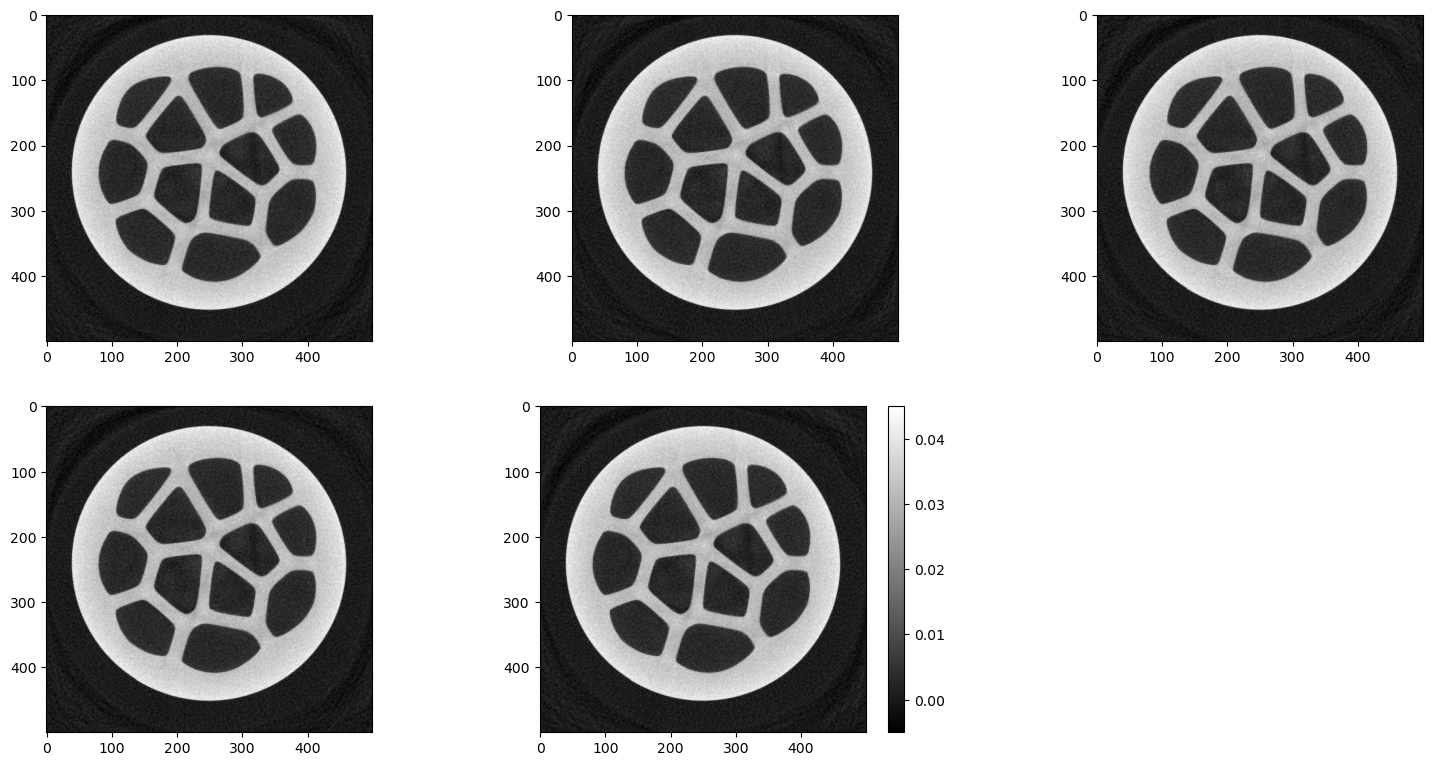

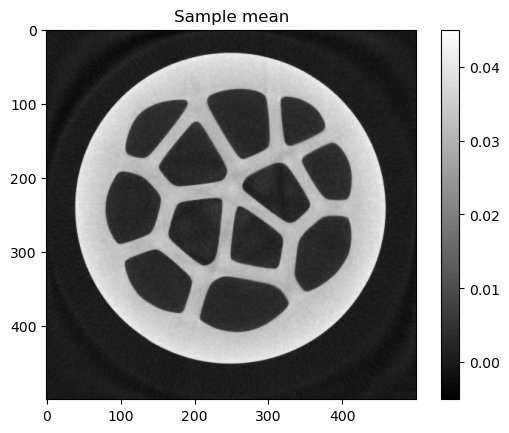

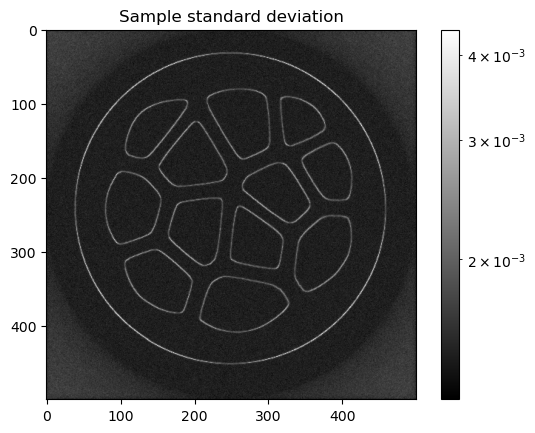

<Figure size 640x480 with 0 Axes>

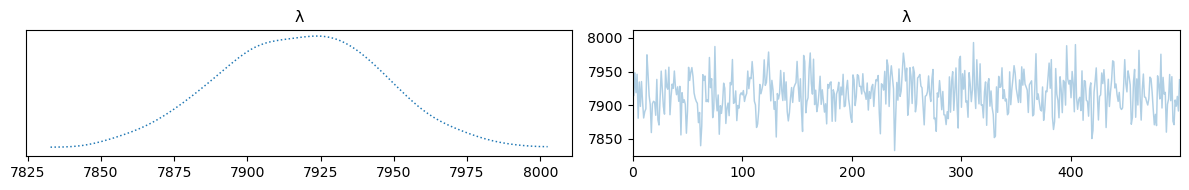

<Figure size 640x480 with 0 Axes>

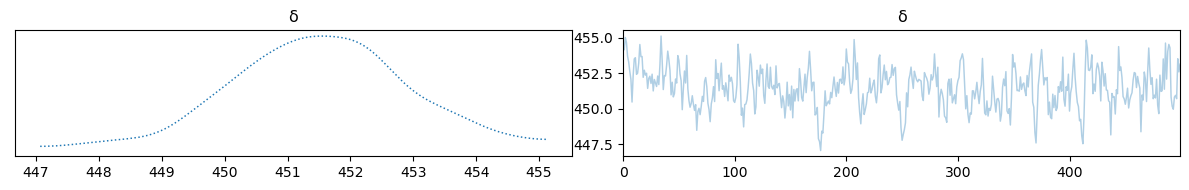

In [6]:
# Plot posterior x samples
plt.figure()
samples_Gibbs["x"].plot(vmin = -0.005, vmax = 0.045)
plt.colorbar()

# Plot x mean
plt.figure()
samples_Gibbs["x"].plot_mean(vmin = -0.005, vmax = 0.045)
plt.colorbar()

# Plot x std
plt.figure()
from matplotlib import colors
samples_Gibbs["x"].plot_std(norm=colors.LogNorm())
plt.colorbar()

# Plot posterior λ samples
plt.figure()
samples_Gibbs["λ"].plot_trace()

# Plot posterior δ samples
plt.figure()
samples_Gibbs["δ"].plot_trace()

λ effective sample size: [377.87035472]
δ effective sample size: [137.29052457]


<Figure size 640x480 with 0 Axes>

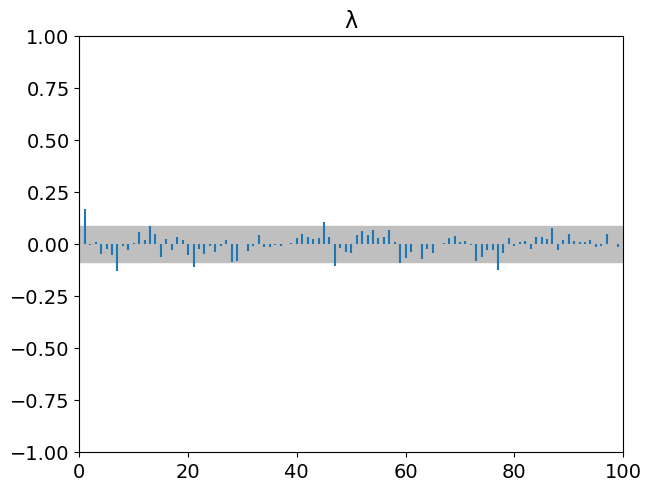

<Figure size 640x480 with 0 Axes>

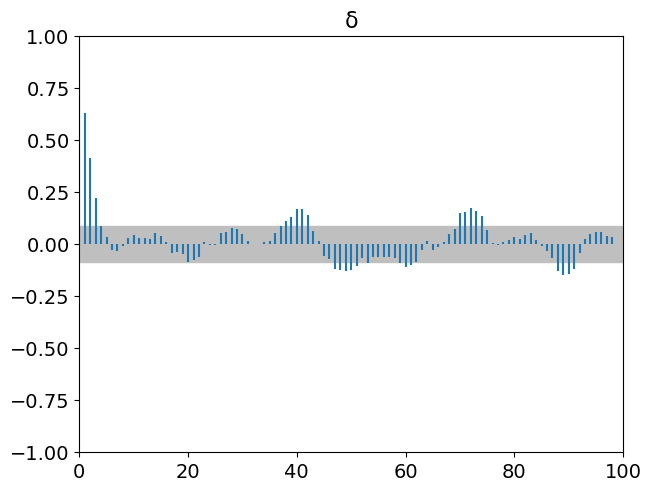

In [7]:
# Plot diagnostics
plt.figure()
samples_Gibbs["λ"].plot_autocorrelation()
plt.figure()
samples_Gibbs["δ"].plot_autocorrelation()

# Effective sample size
print("λ effective sample size: {}".format(samples_Gibbs["λ"].compute_ess()))
print("δ effective sample size: {}".format(samples_Gibbs["δ"].compute_ess()))